In [1]:
import os
import pickle
import numpy as np
from mne import viz
from scipy import io, stats
from matplotlib import colors, pyplot as plt

In [2]:
CAF_DOSE = 200

#ESTIMATOR_PATH = 'C:\\Users\\Philipp\\GoogleDrive\\Caffeine\\results\\randomForest{dose}'.format(dose=CAF_DOSE)
ESTIMATOR_PATH = 'C:\\Users\\Philipp\\Documents\\Caffeine\\results\\randomForest{dose}'.format(dose=CAF_DOSE)
PROJECT_PATH = '..\\data'

STAGES = ['AWA', 'AWSL', 'NREM', 'REM']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
# load a dictionary of sleep stages containing a list of trained random forest estimators
with open(os.path.join(ESTIMATOR_PATH, 'estimators.pickle'), 'rb') as file:
    estimators = pickle.load(file)

# load a dictionary of sleep stages containing a list of different testing data for each estimator
with open(os.path.join(ESTIMATOR_PATH, 'testing_data.pickle'), 'rb') as file:
    data = pickle.load(file)

# load a list of feature names
with open(os.path.join(ESTIMATOR_PATH, 'feature_names.pickle'), 'rb') as file:
    feature_names = pickle.load(file)

C:\Users\Philipp\Anaconda3\envs\mne\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Philipp\Anaconda3\envs\mne\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Grid search parameter exploration

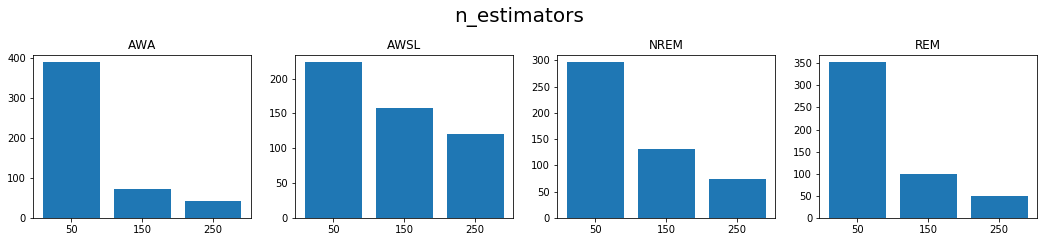

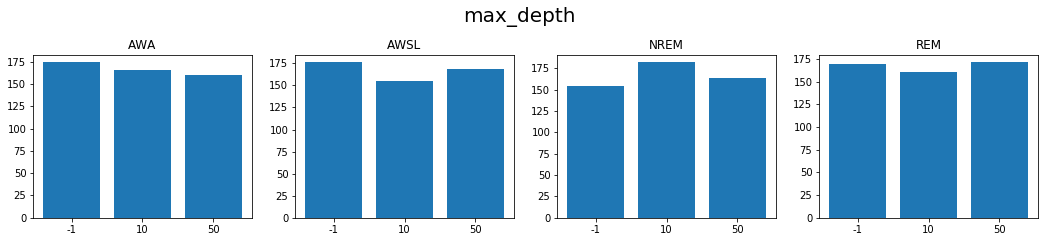

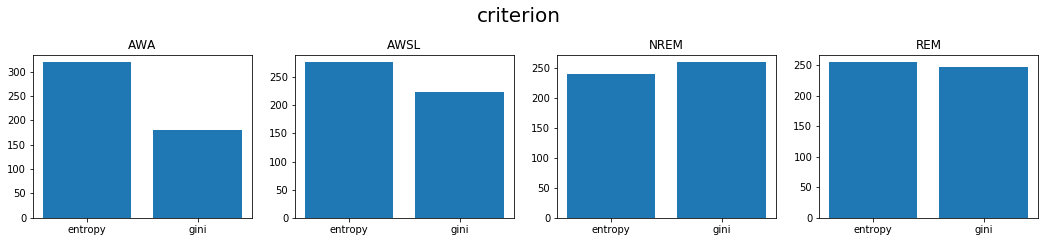

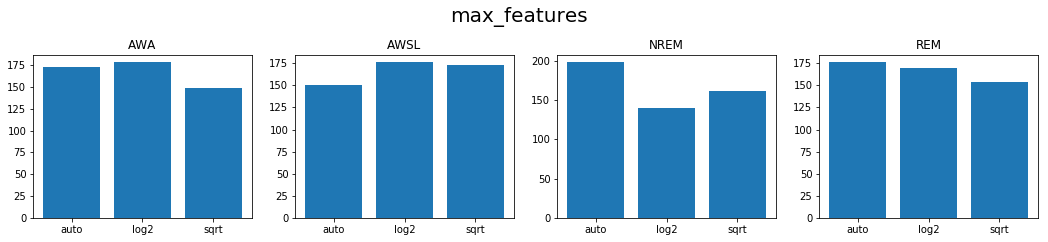

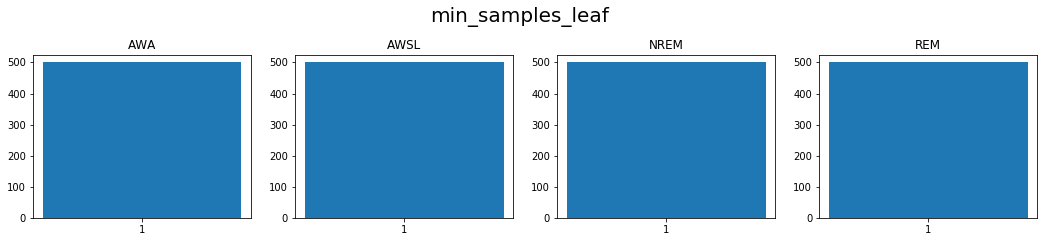

In [5]:
def plot_param_distribution(estimators, param):
    plt.figure(figsize=(18, 3))
    plt.suptitle(param, fontsize=20, y=1.1)
    
    for i, stage in enumerate(STAGES):
        values = np.array([getattr(est, param) for est in estimators[stage]])
        values[[value is None for value in values]] = -1
        uniques = np.unique(values)
        amounts = [len(values[values==value]) for value in uniques]
        
        plt.subplot(1, 4, i + 1)
        plt.title(stage)
        plt.bar(range(len(amounts)), amounts)
        plt.xticks(range(len(amounts)), uniques)
    
    plt.show()


plot_param_distribution(estimators, 'n_estimators')
plot_param_distribution(estimators, 'max_depth')
plot_param_distribution(estimators, 'criterion')
plot_param_distribution(estimators, 'max_features')
plot_param_distribution(estimators, 'min_samples_leaf')

# Accuracy distribution over sleep stages

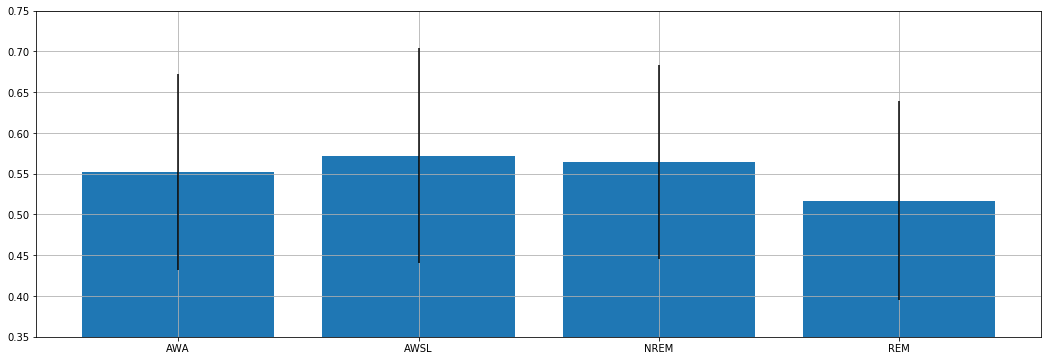

In [6]:
scores = []
for stage in STAGES:
    # calculate scores for each classifier on its test data in each stage
    scores.append(np.array([est.score(*data) for est, data in zip(estimators[stage], data[stage])]))

plt.figure(figsize=(18, 6))
# plot mean estimator scores with std
plt.bar(np.arange(len(STAGES)), [score.mean() for score in scores], yerr=[score.std() for score in scores])
plt.xticks(range(len(STAGES)), STAGES)
plt.ylim(0.35, 0.75)
plt.grid()
plt.show()

# Sorted feature importance for sleep stages

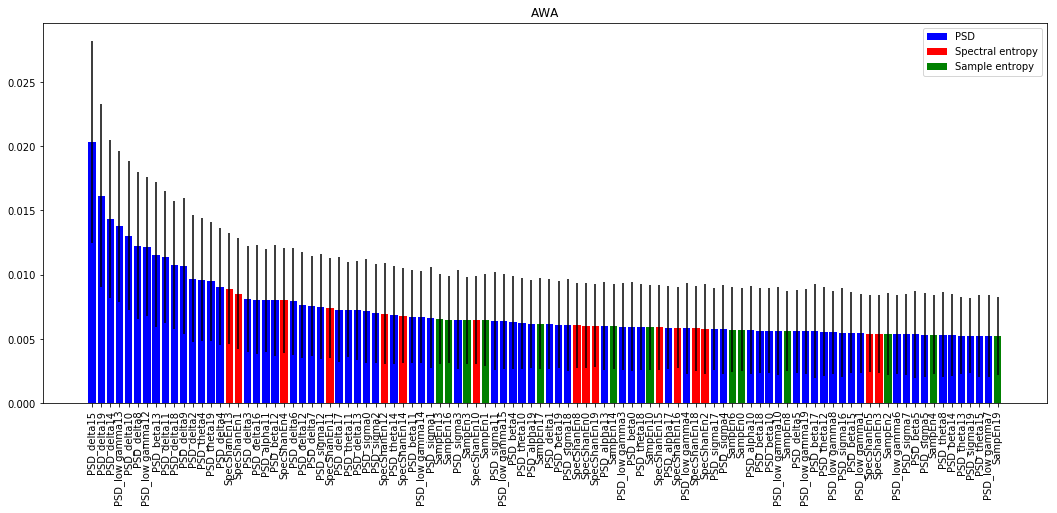

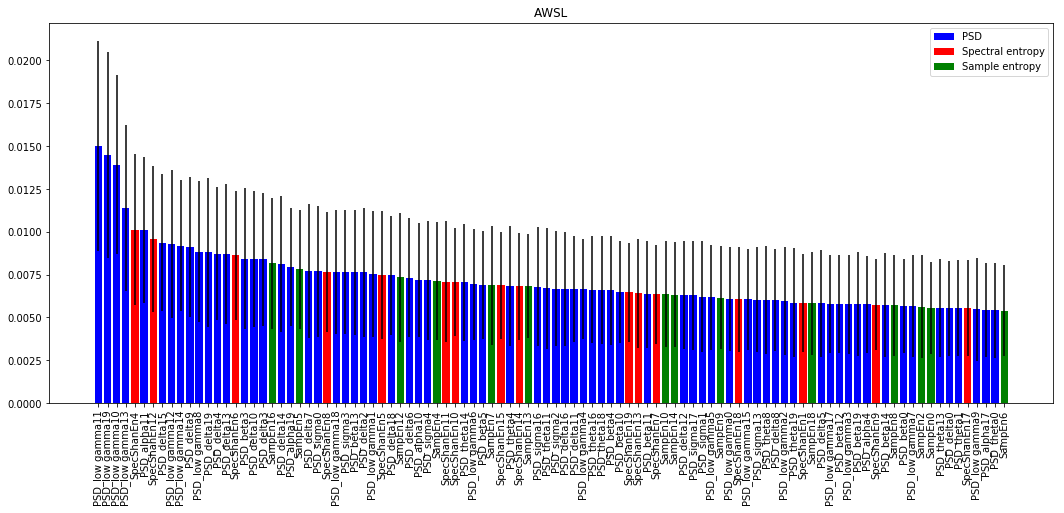

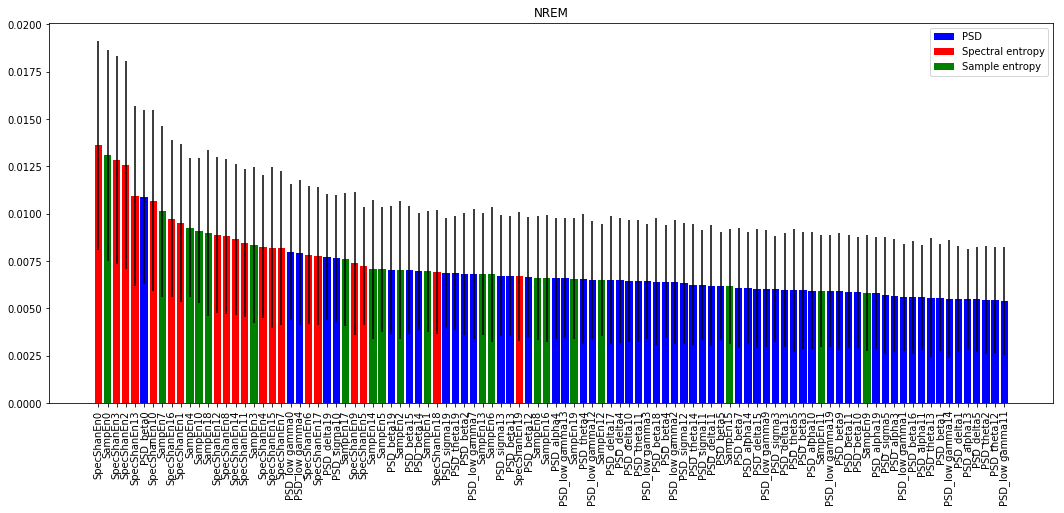

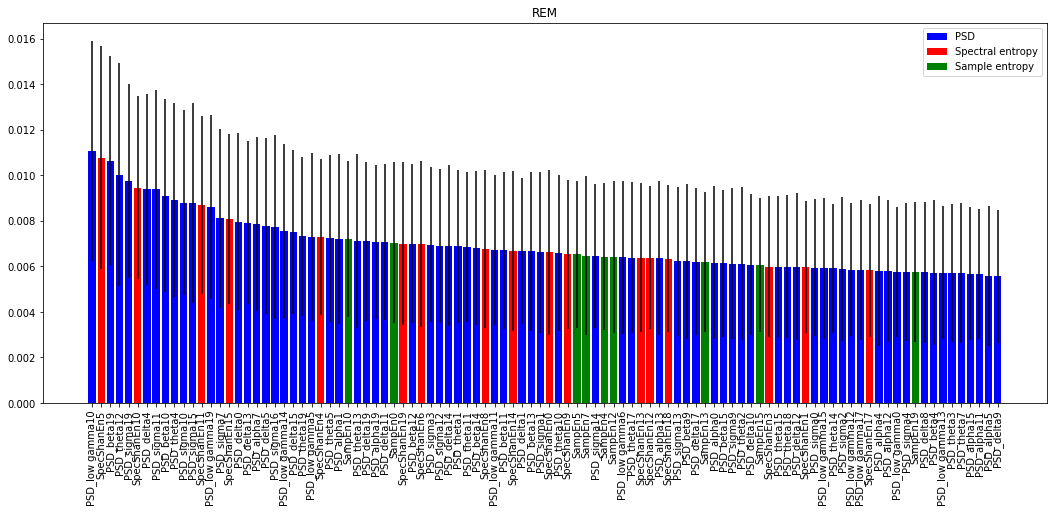

In [7]:
for stage in STAGES:
    # get feature importances from all estimators, calculate mean and std
    importances = [est.feature_importances_ for est in estimators[stage]]
    means = np.mean(importances, axis=0)
    stds = np.std(importances, axis=0)
    
    # get a list with indices to order feature importance values
    order = np.argsort(means)[::-1][:100]

    cols = []
    # create a list of colors for the different kinds of features
    for name in feature_names[order]:
        if 'PSD' in name:
            cols.append('b')
        elif 'Spec' in name:
            cols.append('r')
        elif 'Samp' in name:
            cols.append('g')
    cols = np.array(cols)
            
    plt.figure(figsize=(18, 7))
    plt.title(stage)
    
    #plot PSD feature (color 'b')
    plt.bar(np.arange(len(order))[cols=='b'], means[order][cols=='b'], yerr=stds[order][cols=='b'], color=cols[cols=='b'], label='PSD')
    #plot SpecEn feature (color 'r')
    plt.bar(np.arange(len(order))[cols=='r'], means[order][cols=='r'], yerr=stds[order][cols=='r'], color=cols[cols=='r'], label='Spectral entropy')
    #plot SampEn feature (color 'g')
    plt.bar(np.arange(len(order))[cols=='g'], means[order][cols=='g'], yerr=stds[order][cols=='g'], color=cols[cols=='g'], label='Sample entropy')
    
    plt.xticks(range(len(order)), feature_names[order], rotation=90)
    plt.legend()
    plt.show()

# Feature importance for PSD, SampEn and SpecEn over sleep stages

In [8]:
means = []
stds = []
for stage in STAGES:
    # calculate feature importance for each estimator
    importances = np.array([rf.feature_importances_ for rf in estimators[stage]]).T

    # get the feature importances for PSD, SpecEn and SampEn individually
    psd = np.array([value for value, name in zip(importances, feature_names) if 'PSD' in name])
    spec = np.array([value for value, name in zip(importances, feature_names) if 'Spec' in name])
    samp = np.array([value for value, name in zip(importances, feature_names) if 'Samp' in name])
    
    # calculate feature importance means
    psd_mean = np.mean(psd.flatten())
    spec_mean = np.mean(spec.flatten())
    samp_mean = np.mean(samp.flatten())
    
    # calculate feature importance standard deviations
    psd_std = np.std(psd.flatten())
    spec_std = np.std(spec.flatten())
    samp_std = np.std(samp.flatten())
    
    means.append([psd_mean, spec_mean, samp_mean])
    stds.append([psd_std, spec_std, samp_std])

means = np.array(means)
stds = np.array(stds)

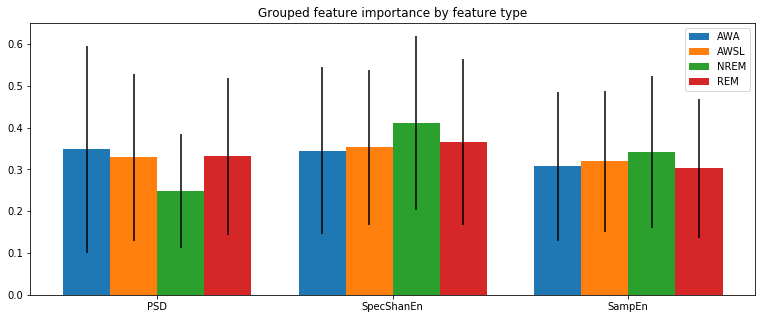

In [9]:
offset = 0
width = 0.2

plt.figure(figsize=(13, 5))
plt.title('Grouped feature importance by feature type')

for i, stage in enumerate(STAGES):
    # plot importance bars for PSD, SpecEn and SampEn grouped by features
    plt.bar(np.arange(3) + offset, means[i] / means[i].sum(), yerr=stds[i] / means[i].sum(), width=width, align='center', label=stage)
    offset += width
    
plt.xticks(np.arange(3) + width * 1.5, ['PSD', 'SpecShanEn', 'SampEn'])
plt.legend()
plt.show()

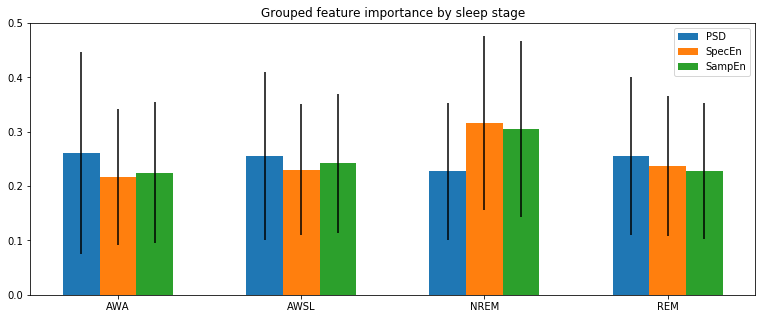

In [10]:
offset = 0
width = 0.2

features = ['PSD', 'SpecEn', 'SampEn']

plt.figure(figsize=(13, 5))
plt.title('Grouped feature importance by sleep stage')

for i in range(3):
    # plot importance bars for PSD, SpecEn and SampEn grouped by sleep stage
    plt.bar(np.arange(4) + offset, means[:,i] / means[:,i].sum(), yerr=stds[:,i] / means[:,i].sum(), width=width, label=features[i])
    offset += width
    
plt.xticks(np.arange(4) + width, STAGES)
plt.legend()
plt.show()

# Feature importance topomaps

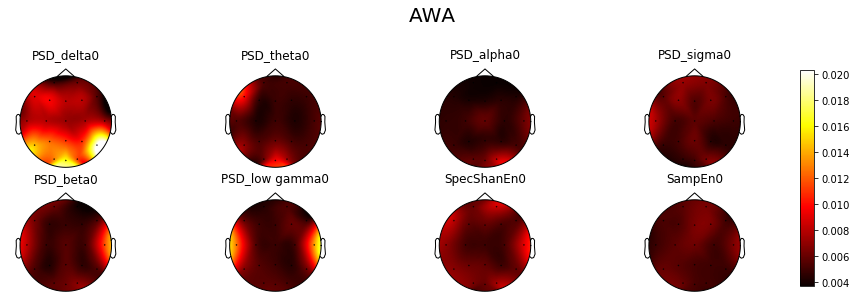

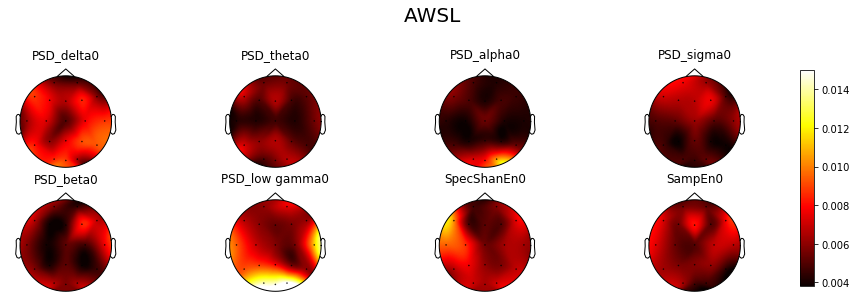

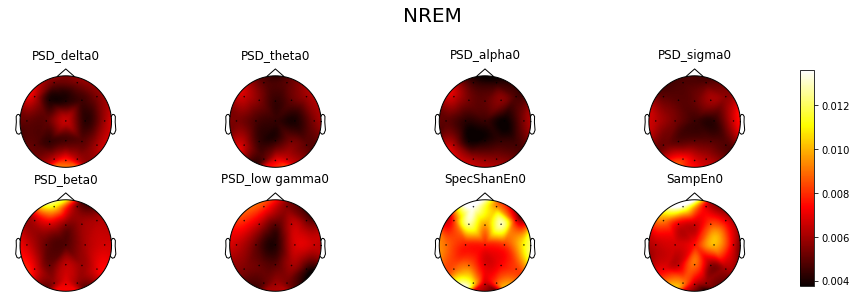

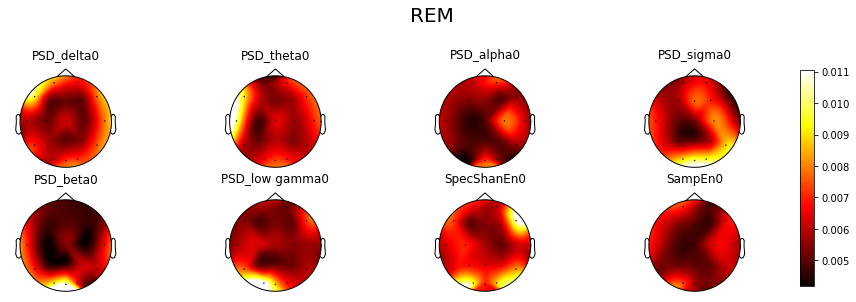

In [11]:
colormap = 'hot'

for stage in STAGES:
    # average feature importance values from all estimators
    importances = np.mean([rf.feature_importances_ for rf in estimators[stage]], axis=0)
    
    importances = importances.reshape((-1, 20))
    features = feature_names[::20]
    
    # get min and max importance values for the colorbar
    vmin = np.min(importances)
    vmax = np.max(importances)
    
    plt.figure(figsize=(18, 8))
    plt.suptitle(stage, y=1.05, fontsize=20)
    
    axes = []
    for i in range(importances.shape[0]):
        # add a new subplot and plot the current feature's topomap
        axes.append(plt.subplot(4, 4, i + 1))
        plt.title(features[i].split('-')[0])
        viz.plot_topomap(importances[i], sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
    
    # add a colorbar to the figure
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=0.95, aspect=15)
    plt.show()